<a href="https://colab.research.google.com/github/andreglim4/GS-Andre-2-sem/blob/main/GS_andre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Limite de Consumo ALTO (Q3): 1.4330 kWh
Total de ocorrências de Consumo ALTO (1): 180 (25.00%)
--------------------------------------------------

--- 1. Vilões de Consumo (Total por Dispositivo) ---
dispositivo
Ar Condicionado    421.696
Servidor           147.791
Computadores        49.990
Iluminação          42.287
Micro-ondas         26.525
Geladeira           11.842
Cafeteira            5.438
Impressora           4.461
Projetor             4.234

--- 2. Consumo Total por Área do Escritório ---
area
Escritório Aberto    383.425
TI/Servidor          120.162
Sala de Reunião       76.888
Recepção              72.059
Copa                  61.730

--- 3. Média de Consumo por Hora do Dia ---
hora
8     0.818883
9     0.745783
10    0.921150
11    1.017883
12    1.375567
13    1.248800
14    1.131033
15    0.774583
16    0.975383
17    1.112017
18    0.826200
19    0.957117

--- 4. Detalhe do Desperdício em Fim de Semana (FDS) ---
Consumo Total Dias Úteis: 437.69 kWh
Consumo Total Fim de 

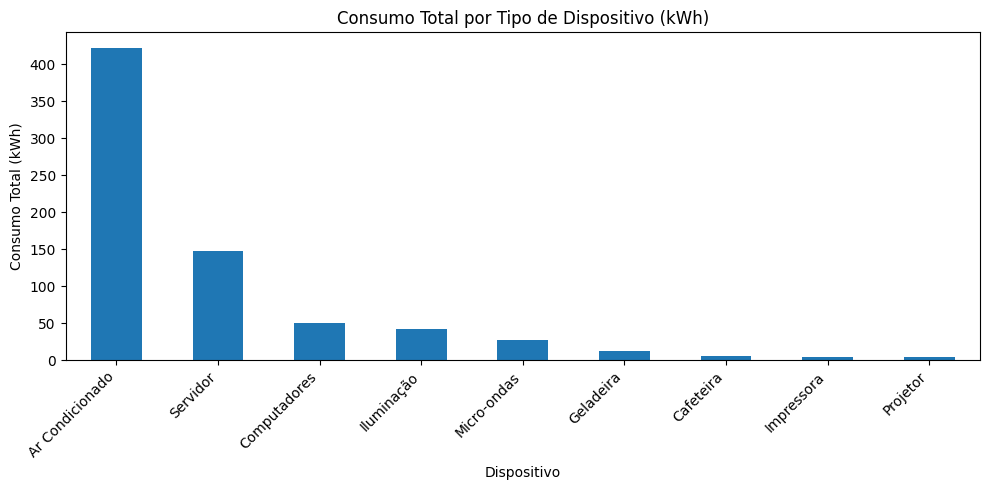

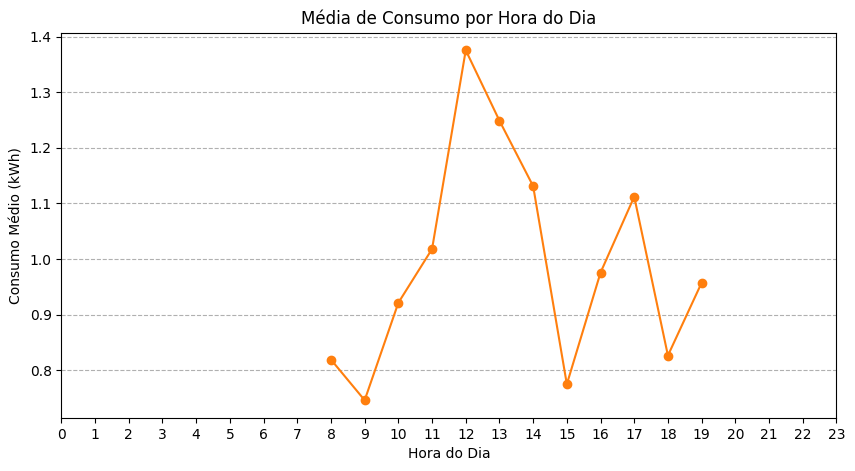

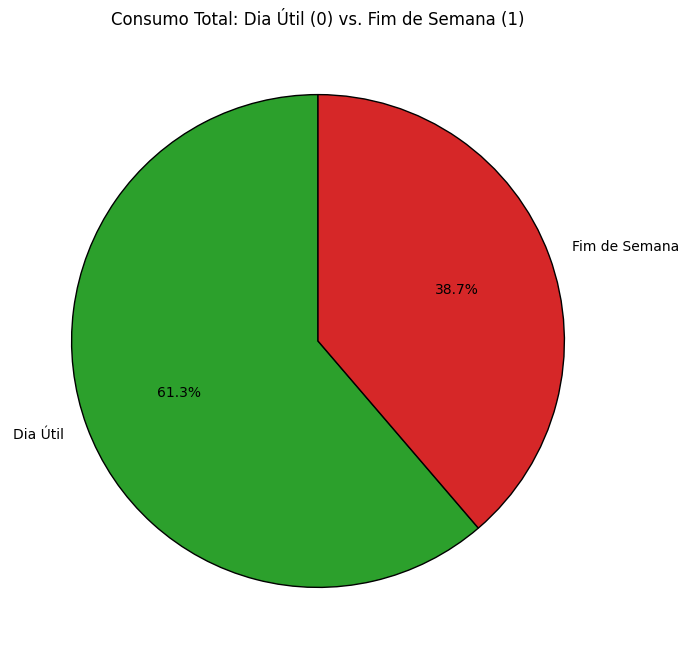

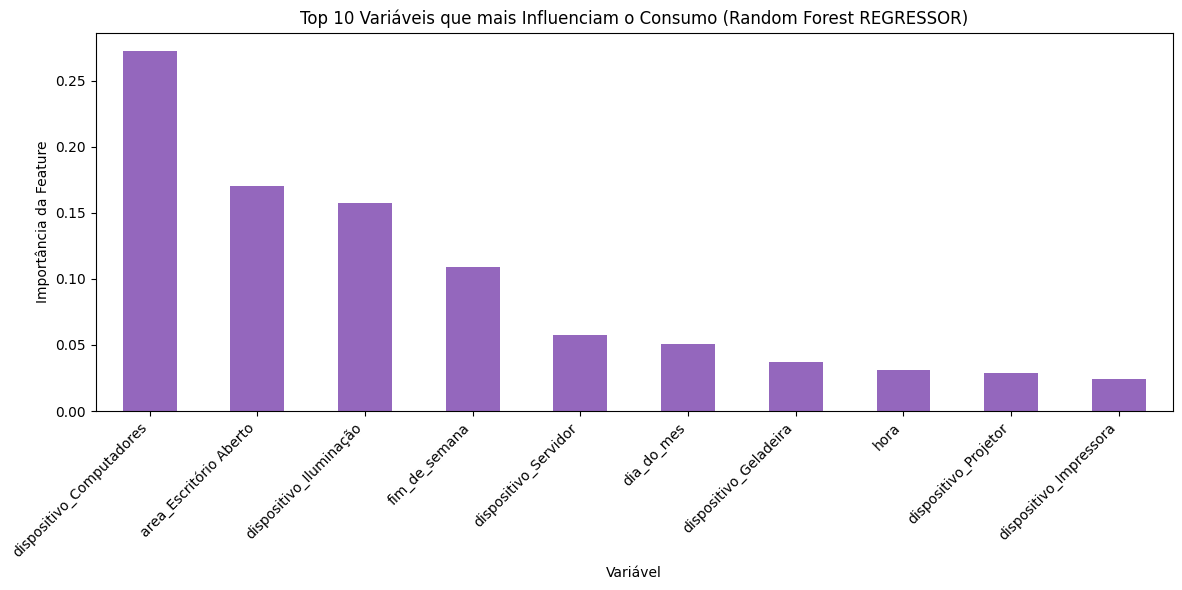

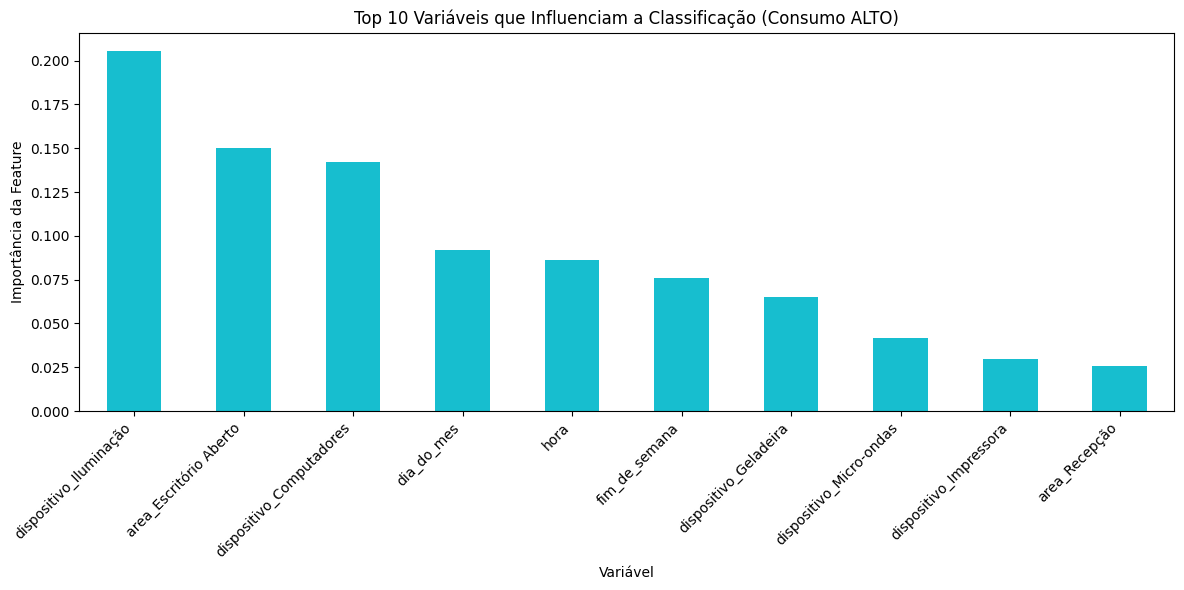

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier # Importação do Classifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
import numpy as np
import warnings

# Ignorar FutureWarning do Scikit-learn e Pandas para manter a saída limpa
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# --- Configuração Inicial e Carregamento de Dados ---
# Carregar os dados
try:
    df = pd.read_csv('dados_consumo_escritorio_60dias.csv')
except FileNotFoundError:
    print("ERRO: O arquivo 'dados_consumo_escritorio_60dias.csv' não foi encontrado. Certifique-se de que ele está no diretório correto.")
    exit()

# Engenharia de Features Básica (Mantida)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hora'] = df['timestamp'].dt.hour
df['dia_semana_nome'] = df['timestamp'].dt.day_name()
df['dia_do_mes'] = df['timestamp'].dt.day
df['mes'] = df['timestamp'].dt.month
df['fim_de_semana'] = df['dia_semana_nome'].isin(['Saturday', 'Sunday']).astype(int) # 1 para FDS, 0 para Dia Útil

# --- NOVO: Feature Target para CLASSIFICAÇÃO ---
# Definir um limite para consumo ALTO. Usaremos o 75º percentil (Q3)
limite_alto = df['consumo_kWh'].quantile(0.75)
print(f"Limite de Consumo ALTO (Q3): {limite_alto:.4f} kWh")

# Criar a coluna de classificação: 1 se consumo > limite_alto, 0 caso contrário
df['nivel_consumo'] = (df['consumo_kWh'] > limite_alto).astype(int)
print(f"Total de ocorrências de Consumo ALTO (1): {df['nivel_consumo'].sum()} ({df['nivel_consumo'].mean() * 100:.2f}%)")
print("-" * 50)


# --- 1. Análise Exploratória Aprofundada (Mantida) ---

# 1.1 Vilões de Consumo por Dispositivo
consumo_por_dispositivo = df.groupby('dispositivo')['consumo_kWh'].sum().sort_values(ascending=False)
print("\n--- 1. Vilões de Consumo (Total por Dispositivo) ---")
print(consumo_por_dispositivo.to_string())

# 1.2 Média de Consumo por Área
consumo_por_area = df.groupby('area')['consumo_kWh'].sum().sort_values(ascending=False)
print("\n--- 2. Consumo Total por Área do Escritório ---")
print(consumo_por_area.to_string())

# 1.3 Picos de Consumo Horário e Diário
media_consumo_hora = df.groupby('hora')['consumo_kWh'].mean()
print("\n--- 3. Média de Consumo por Hora do Dia ---")
print(media_consumo_hora.to_string())

# 1.4 Análise de Desperdício Detalhado (FDS)
consumo_fds_detalhe = df[df['fim_de_semana'] == 1].groupby('dispositivo')['consumo_kWh'].sum().sort_values(ascending=False)
consumo_dia_util_total = df[df['fim_de_semana'] == 0]['consumo_kWh'].sum()
consumo_fds_total = df[df['fim_de_semana'] == 1]['consumo_kWh'].sum()
proporcao_fds = (consumo_fds_total / (consumo_fds_total + consumo_dia_util_total)) * 100

print(f"\n--- 4. Detalhe do Desperdício em Fim de Semana (FDS) ---")
print(f"Consumo Total Dias Úteis: {consumo_dia_util_total:.2f} kWh")
print(f"Consumo Total Fim de Semana: {consumo_fds_total:.2f} kWh ({proporcao_fds:.1f}% do total)")
print("\nTop Dispositivos Consumindo no FDS (Potencial Desperdício):")
print(consumo_fds_detalhe.to_string())

# O desperdício principal (AC no Escritório Aberto no FDS)
desperdicio_ac_fds = df[
    (df['dispositivo'] == 'Ar Condicionado') &
    (df['area'] == 'Escritório Aberto') &
    (df['fim_de_semana'] == 1)
]
total_desperdicio_ac = desperdicio_ac_fds['consumo_kWh'].sum()
print(f"\nAlerta de Desperdício Focado (AC no Escritório Aberto no FDS): {total_desperdicio_ac:.2f} kWh")

# --- 2. Preparação de Dados para Machine Learning (Regression) ---

print("\n" + "=" * 50)
print("INÍCIO DA REGRESSÃO: RANDOM FOREST REGRESSOR (Previsão de kWh)")
print("=" * 50)

# Features a serem usadas (X) e Variável Target (Y)
features_reg = ['hora', 'fim_de_semana', 'dia_do_mes', 'dispositivo', 'area']
target_reg = 'consumo_kWh'

X_reg = df[features_reg]
y_reg = df[target_reg]

# One-Hot Encoding para features categóricas (Dispositivo, Área)
X_reg = pd.get_dummies(X_reg, columns=['dispositivo', 'area'], drop_first=True)
X_reg = X_reg.drop(columns=['mes'], errors='ignore') # 'mes' já tem o efeito capturado pelo 'dia_do_mes'

print(f"Total de Features para Regressão: {X_reg.shape[1]}")

# Separação dos dados de treino e teste
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# --- 3. Treinamento e Avaliação do Modelo Random Forest REGRESSION ---
rf_model_r = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10, min_samples_leaf=5)
rf_model_r.fit(X_train_r, y_train_r)

y_pred_r = rf_model_r.predict(X_test_r)

rmse_r = np.sqrt(mean_squared_error(y_test_r, y_pred_r))
r2_r = r2_score(y_test_r, y_pred_r)

print("\n--- Avaliação do Modelo Random Forest REGRESSOR ---")
print(f"Raiz do Erro Quadrático Médio (RMSE): {rmse_r:.4f} kWh")
print(f"Coeficiente de Determinação (R²): {r2_r:.4f}")

# --- 4. Análise de Importância das Features (Regression) ---
feature_importances_r = pd.Series(rf_model_r.feature_importances_, index=X_reg.columns)
feature_importances_r = feature_importances_r.sort_values(ascending=False)
print("\n--- 5. Top 5 Features para REGRESSÃO (O que mais impulsiona o consumo) ---")
print(feature_importances_r.head(5).to_string())


# --- 5. CLASSIFICAÇÃO: Previsão de Nível de Consumo (Alto/Normal) ---

print("\n" + "=" * 50)
print("INÍCIO DA CLASSIFICAÇÃO: RANDOM FOREST CLASSIFIER (Prever Nível Alto)")
print("=" * 50)

# Features a serem usadas (mesmas que na regressão)
features_class = ['hora', 'fim_de_semana', 'dia_do_mes', 'dispositivo', 'area']
target_class = 'nivel_consumo'

X_class = df[features_class]
y_class = df[target_class]

# One-Hot Encoding para features categóricas (Dispositivo, Área)
X_class = pd.get_dummies(X_class, columns=['dispositivo', 'area'], drop_first=True)
X_class = X_class.drop(columns=['mes'], errors='ignore')


# Separação dos dados de treino e teste para CLASSIFICAÇÃO (stratify para manter a proporção de 0s e 1s)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_class, y_class, test_size=0.2, random_state=42, stratify=y_class)

print(f"Total de Features para Classificação: {X_class.shape[1]}")
print(f"Tamanho do conjunto de Treino (Classificação): {len(X_train_c)} amostras")
print(f"Tamanho do conjunto de Teste (Classificação): {len(X_test_c)} amostras")

# Inicializar e treinar o Random Forest Classifier (class_weight='balanced' para lidar com classes desbalanceadas)
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10, class_weight='balanced')
rf_classifier.fit(X_train_c, y_train_c)

# Fazer previsões no conjunto de teste
y_pred_c = rf_classifier.predict(X_test_c)

# Avaliação do modelo de CLASSIFICAÇÃO
accuracy = accuracy_score(y_test_c, y_pred_c)
report = classification_report(y_test_c, y_pred_c, target_names=['Normal (0)', 'Alto (1)'])

print("\n--- Avaliação do Modelo Random Forest CLASSIFIER ---")
print(f"Acurácia: {accuracy:.4f}")
print("\nRelatório de Classificação (Precisão, Recall, F1-Score):")
print(report)

# --- 6. Importância das Features para CLASSIFICAÇÃO ---

# Extrair e visualizar a importância das variáveis para CLASSIFICAÇÃO
feature_importances_c = pd.Series(rf_classifier.feature_importances_, index=X_class.columns)
feature_importances_c = feature_importances_c.sort_values(ascending=False)

print("\n--- 7. Top 5 Features para CLASSIFICAÇÃO (Previsão de Consumo ALTO) ---")
print(feature_importances_c.head(5).to_string())

# --- 7. Visualização (Incluindo resultados do ML) ---

# Gráfico 1: Consumo total por dispositivo (Existente)
plt.figure(figsize=(10, 5))
consumo_por_dispositivo.plot(kind='bar', color='#1f77b4')
plt.title('Consumo Total por Tipo de Dispositivo (kWh)')
plt.ylabel('Consumo Total (kWh)')
plt.xlabel('Dispositivo')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Gráfico 2: Média de consumo por hora (Existente)
plt.figure(figsize=(10, 5))
media_consumo_hora.plot(kind='line', marker='o', color='#ff7f0e')
plt.title('Média de Consumo por Hora do Dia')
plt.xlabel('Hora do Dia')
plt.ylabel('Consumo Médio (kWh)')
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--')

# Gráfico 3: Comparação Dia Útil vs. Fim de Semana (Existente)
plt.figure(figsize=(8, 8))
df.groupby('fim_de_semana')['consumo_kWh'].sum().plot(
    kind='pie',
    autopct='%1.1f%%',
    labels=['Dia Útil', 'Fim de Semana'],
    colors=['#2ca02c', '#d62728'],
    startangle=90,
    wedgeprops={'edgecolor': 'black'}
)
plt.ylabel('')
plt.title('Consumo Total: Dia Útil (0) vs. Fim de Semana (1)')

# Gráfico 4: Importância das Features (Resultado do ML - Regressão)
plt.figure(figsize=(12, 6))
feature_importances_r.head(10).plot(kind='bar', color='#9467bd')
plt.title('Top 10 Variáveis que mais Influenciam o Consumo (Random Forest REGRESSOR)')
plt.ylabel('Importância da Feature')
plt.xlabel('Variável')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# NOVO GRÁFICO 5: Importância das Features para Classificação
plt.figure(figsize=(12, 6))
feature_importances_c.head(10).plot(kind='bar', color='#17becf')
plt.title('Top 10 Variáveis que Influenciam a Classificação (Consumo ALTO)')
plt.ylabel('Importância da Feature')
plt.xlabel('Variável')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()